In [1]:
import os
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import seaborn as sns

%config InlineBackend.figure_format = "retina"

Plan:

1. Feature selection: condition number and VIF
2. Data preparation: scaler, label encoding
3. Hyparparameters tuning with CV, penalty=L2
4. Model interpretation

In [2]:
# Configuration
TEST_SIZE = 0.2
SEED = 42
CROSSVAL_SIZE = 5
CLASS_NAMES = ["tripustulatus", "punctatus", "pabulinus"]
# CLASS_IDS = [idx for idx in range(len(CLASS_NAMES))]
SCORING = "roc_auc"
PENALTY = "l2"
COLOR_MAP =  {name: color for name,color in zip(CLASS_NAMES, ["#DD8D29", "#E2D200", "#46ACC8"]) }
# What pair of classes to use
CLASSES = ["tripustulatus", "punctatus"]

### Reading data

In [3]:
filepath = os.path.join("data", "df_bio.csv")
if "df_bio.csv" in os.listdir("data"):
    print("Reading existing full table")
    df_bio = pd.read_csv(filepath)
else:
    print("Preparing full table")
    df_bio = pd.concat([pd.read_csv(os.path.join("data", name)) for name in os.listdir("data")])
    df_bio = df_bio.reset_index(drop=True)
    df_bio = df_bio.sample(frac=1)
    df_bio.to_csv(filepath, index=False)

Reading existing full table


In [4]:
df_bio = df_bio[df_bio["species"].isin(CLASSES)]

In [5]:
df_bio.head(10)

,species,longitude,latitude,bio01,bio02,bio03,bio04,bio05,bio06,bio07,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,tripustulatus,-2.904473,43.304850,136,64,36,4025,231,58,173,...,189,87,1203,156,48,29,406,190,222,406
1,punctatus,87.730000,53.710000,18,114,24,12905,260,-214,474,...,180,-153,474,73,14,55,212,46,212,53
2,tripustulatus,27.826083,44.089939,113,84,27,7714,268,-33,301,...,210,12,483,58,31,19,154,95,144,104
4,tripustulatus,40.620000,43.100000,144,83,32,6118,275,22,253,...,221,67,1447,151,93,14,426,310,338,388
9,tripustulatus,41.815000,42.534000,142,91,34,6427,279,13,266,...,222,59,1759,180,89,18,511,336,509,428
10,punctatus,127.500000,62.400000,-105,108,16,20656,239,-434,673,...,149,-376,280,48,7,61,137,25,137,32
12,tripustulatus,23.127043,55.355872,62,76,25,7947,217,-78,295,...,161,-42,670,83,29,28,229,107,229,125
13,tripustulatus,26.589000,48.681000,81,90,27,8463,243,-80,323,...,184,-32,636,101,30,45,271,94,263,101
15,punctatus,108.621670,58.023060,-45,129,22,15946,242,-332,574,...,154,-257,386,64,11,52,171,41,171,57
17,punctatus,40.188000,58.089000,34,82,21,10372,229,-154,383,...,164,-103,611,84,27,32,220,92,220,112


In [6]:
df_bio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 0 to 592
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    348 non-null    object 
 1   longitude  348 non-null    float64
 2   latitude   348 non-null    float64
 3   bio01      348 non-null    int64  
 4   bio02      348 non-null    int64  
 5   bio03      348 non-null    int64  
 6   bio04      348 non-null    int64  
 7   bio05      348 non-null    int64  
 8   bio06      348 non-null    int64  
 9   bio07      348 non-null    int64  
 10  bio08      348 non-null    int64  
 11  bio09      348 non-null    int64  
 12  bio10      348 non-null    int64  
 13  bio11      348 non-null    int64  
 14  bio12      348 non-null    int64  
 15  bio13      348 non-null    int64  
 16  bio14      348 non-null    int64  
 17  bio15      348 non-null    int64  
 18  bio16      348 non-null    int64  
 19  bio17      348 non-null    int64  
 20  bio18      348 

### Feature selection

In [7]:
def best_feats_via_cond_numebr(df: pd.DataFrame, n_limit: int) -> pd.DataFrame:
    
    """
    Find best features combination of size n based on matrix condition number value
    """
    all_features = get_features(df)
    
    output = dict()
    
    for n in tqdm.notebook.tqdm(list(range(1, n_limit + 1))):

        best_feats = None
        best_cond_val = np.inf
        coms = list(combinations(all_features, n))

        for feats_combination in tqdm.notebook.tqdm(coms):

            cond_val = np.linalg.cond(df[[*feats_combination]].values)

            if cond_val < best_cond_val:
                best_cond_val = cond_val
                best_feats = feats_combination
                
        output.update({n: {"BestConditionVal": best_cond_val, "Features": best_feats}})
        
    return pd.DataFrame(output).T

In [8]:
def get_features(df: pd.DataFrame) -> list[str]:
    """
    Extract features from full table
    """
    to_exclude = ["longitude", "latitude", "species"]
    features = [x for x in df.columns.tolist() if x not in to_exclude]
    return features

In [9]:
# df_res = best_feats_via_cond_numebr(df_bio, 9)
# df_res.to_csv("df_res_lio_pun.csv", index=False)
df_res = pd.read_csv("df_res_lio_pun.csv")
df_res

,BestConditionVal,Features
0,1.000000,"('bio01',)"
1,1.179136,"('bio09', 'bio17')"
2,3.525581,"('bio02', 'bio09', 'bio17')"
3,5.608409,"('bio08', 'bio09', 'bio11', 'bio17')"
4,7.419169,"('bio01', 'bio09', 'bio11', 'bio17', 'bio19')"
5,12.761717,"('bio08', 'bio09', 'bio11', 'bio17', 'bio18', ..."
6,16.705954,"('bio08', 'bio09', 'bio10', 'bio11', 'bio13', ..."
7,28.652747,"('bio02', 'bio08', 'bio09', 'bio10', 'bio11', ..."
8,43.733347,"('bio01', 'bio02', 'bio08', 'bio09', 'bio11', ..."


In [10]:
df_res

,BestConditionVal,Features
0,1.000000,"('bio01',)"
1,1.179136,"('bio09', 'bio17')"
2,3.525581,"('bio02', 'bio09', 'bio17')"
3,5.608409,"('bio08', 'bio09', 'bio11', 'bio17')"
4,7.419169,"('bio01', 'bio09', 'bio11', 'bio17', 'bio19')"
5,12.761717,"('bio08', 'bio09', 'bio11', 'bio17', 'bio18', ..."
6,16.705954,"('bio08', 'bio09', 'bio10', 'bio11', 'bio13', ..."
7,28.652747,"('bio02', 'bio08', 'bio09', 'bio10', 'bio11', ..."
8,43.733347,"('bio01', 'bio02', 'bio08', 'bio09', 'bio11', ..."


In [11]:
def get_vif(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Generate VIF table for a set of desired features
    """
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df[features].columns 
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                              for i in range(len(df[features].columns))] 
    vif_data["VIF"] = vif_data["VIF"].apply(lambda x: np.around(x, 3))
    vif_data = vif_data.sort_values(by=["VIF"], ascending=False)

    return vif_data

In [12]:
selected_features = [*eval(df_res.iloc[5]["Features"])]
get_vif(df_bio, selected_features)

,feature,VIF
4,bio18,21.726
3,bio17,15.486
5,bio19,9.214
0,bio08,7.972
2,bio11,7.924
1,bio09,7.788


In [13]:
selected_features = [*eval(df_res.iloc[4]["Features"])]
get_vif(df_bio, selected_features)

,feature,VIF
4,bio19,9.641
3,bio17,8.152
1,bio09,7.886
2,bio11,6.135
0,bio01,5.651


In [14]:
selected_features = [*eval(df_res.iloc[3]["Features"])]
get_vif(df_bio, selected_features)

,feature,VIF
2,bio11,7.115
0,bio08,5.342
1,bio09,4.924
3,bio17,3.483


We use features `['bio08', 'bio09', 'bio11', 'bio17']` because their combination generates VIF metrics < 10 according to the rule of thumb.

In [15]:
SELECTED_FEATURES = selected_features

### Data preparation

In [17]:
df_prepared = df_bio.copy(deep=True)
df_prepared["species"] = df_prepared["species"].apply(lambda x: CLASSES.index(x))

In [18]:
X, y = df_prepared[SELECTED_FEATURES], df_prepared["species"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=np.random.RandomState(SEED),
                                                    stratify=y)

In [19]:
X_test.head()

,bio08,bio09,bio11,bio17
299,161,-347,-405,18
1,180,-128,-153,46
447,140,-26,-37,144
422,194,-7,-71,99
261,84,19,-8,129


In [20]:
y.value_counts()

species
0    243
1    105
Name: count, dtype: int64

In [21]:
y_test.value_counts()

species
0    49
1    21
Name: count, dtype: int64

In [22]:
y_train.value_counts()

species
0    194
1     84
Name: count, dtype: int64

### Hyperparams tuning 


Standard cross-validation

In [23]:
logreg_cv = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model",
     LogisticRegressionCV(cv=CROSSVAL_SIZE,
                          penalty=PENALTY,
                          scoring=SCORING,
                          Cs=np.linspace(0.001, 0.5, 100))),
])

In [24]:
logreg_cv.fit(X=X_train[SELECTED_FEATURES], y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegressionCV(Cs=array([0.001     , 0.0060404 , 0.01108081, 0.01612121, 0.02116162,
       0.02620202, 0.03124242, 0.03628283, 0.04132323, 0.04636364,
       0.05140404, 0.05644444, 0.06148485, 0.06652525, 0.07156566,
       0.07660606, 0.08164646, 0.08668687, 0.09172727, 0.09676768,
       0.10180808, 0.10684848, 0.11188889, 0.11692929, 0.121969...
       0.32862626, 0.33366667, 0.33870707, 0.34374747, 0.34878788,
       0.35382828, 0.35886869, 0.36390909, 0.36894949, 0.3739899 ,
       0.3790303 , 0.38407071, 0.38911111, 0.39415152, 0.39919192,
       0.40423232, 0.40927273, 0.41431313, 0.41935354, 0.42439394,
       0.42943434, 0.43447475, 0.43951515, 0.44455556, 0.44959596,
       0.45463636, 0.45967677, 0.46471717, 0.46975758, 0.47479798,
       0.47983838, 0.48487879, 0.48991919, 0.4949596 , 0.5       ]),
                                      cv=5, scoring='roc_auc'))])

In [25]:
model_cv = logreg_cv[1]

In [26]:
model_cv.scores_[1]

array([[0.90648567, 0.90648567, 0.90799397, 0.90950226, 0.91251885,
        0.91402715, 0.91402715, 0.91402715, 0.91402715, 0.91402715,
        0.91402715, 0.91251885, 0.91251885, 0.91251885, 0.91251885,
        0.91101056, 0.90950226, 0.90950226, 0.90950226, 0.90950226,
        0.90950226, 0.90799397, 0.90799397, 0.90799397, 0.90799397,
        0.90799397, 0.90799397, 0.90799397, 0.91101056, 0.91101056,
        0.91101056, 0.91101056, 0.91251885, 0.91251885, 0.91251885,
        0.91251885, 0.91251885, 0.91251885, 0.91251885, 0.91251885,
        0.91251885, 0.91402715, 0.91402715, 0.91402715, 0.91402715,
        0.91402715, 0.91402715, 0.91402715, 0.91402715, 0.91402715,
        0.91402715, 0.91402715, 0.91402715, 0.91402715, 0.91402715,
        0.91402715, 0.91402715, 0.91704374, 0.91704374, 0.91704374,
        0.91704374, 0.91704374, 0.91704374, 0.91704374, 0.91704374,
        0.91704374, 0.91704374, 0.91704374, 0.91704374, 0.91704374,
        0.91704374, 0.91704374, 0.91704374, 0.91

In [27]:
[np.mean(x) for x in model_cv.scores_[1]]

[0.9144645550527906,
 0.9407390648567119,
 0.8965761689291105,
 0.8965634674922598,
 0.9756730769230767]

### Model explanation

In [28]:
model_cv.get_params()

{'Cs': array([0.001     , 0.0060404 , 0.01108081, 0.01612121, 0.02116162,
        0.02620202, 0.03124242, 0.03628283, 0.04132323, 0.04636364,
        0.05140404, 0.05644444, 0.06148485, 0.06652525, 0.07156566,
        0.07660606, 0.08164646, 0.08668687, 0.09172727, 0.09676768,
        0.10180808, 0.10684848, 0.11188889, 0.11692929, 0.1219697 ,
        0.1270101 , 0.13205051, 0.13709091, 0.14213131, 0.14717172,
        0.15221212, 0.15725253, 0.16229293, 0.16733333, 0.17237374,
        0.17741414, 0.18245455, 0.18749495, 0.19253535, 0.19757576,
        0.20261616, 0.20765657, 0.21269697, 0.21773737, 0.22277778,
        0.22781818, 0.23285859, 0.23789899, 0.24293939, 0.2479798 ,
        0.2530202 , 0.25806061, 0.26310101, 0.26814141, 0.27318182,
        0.27822222, 0.28326263, 0.28830303, 0.29334343, 0.29838384,
        0.30342424, 0.30846465, 0.31350505, 0.31854545, 0.32358586,
        0.32862626, 0.33366667, 0.33870707, 0.34374747, 0.34878788,
        0.35382828, 0.35886869, 0.36390909

In [29]:
model_cv.C_

array([0.21269697])

In [30]:
final_logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty=PENALTY, C=model_cv.C_[0], random_state=np.random.RandomState(SEED))
    ),
])
final_logreg.fit(X=X_train[SELECTED_FEATURES], y=y_train)

final_model = final_logreg[1]

In [32]:
print(
    classification_report(y_true=y_test,
                          y_pred=final_logreg.predict(X_test[SELECTED_FEATURES]),
                          target_names=CLASSES))

               precision    recall  f1-score   support

tripustulatus       0.86      0.98      0.91        49
    punctatus       0.93      0.62      0.74        21

     accuracy                           0.87        70
    macro avg       0.89      0.80      0.83        70
 weighted avg       0.88      0.87      0.86        70



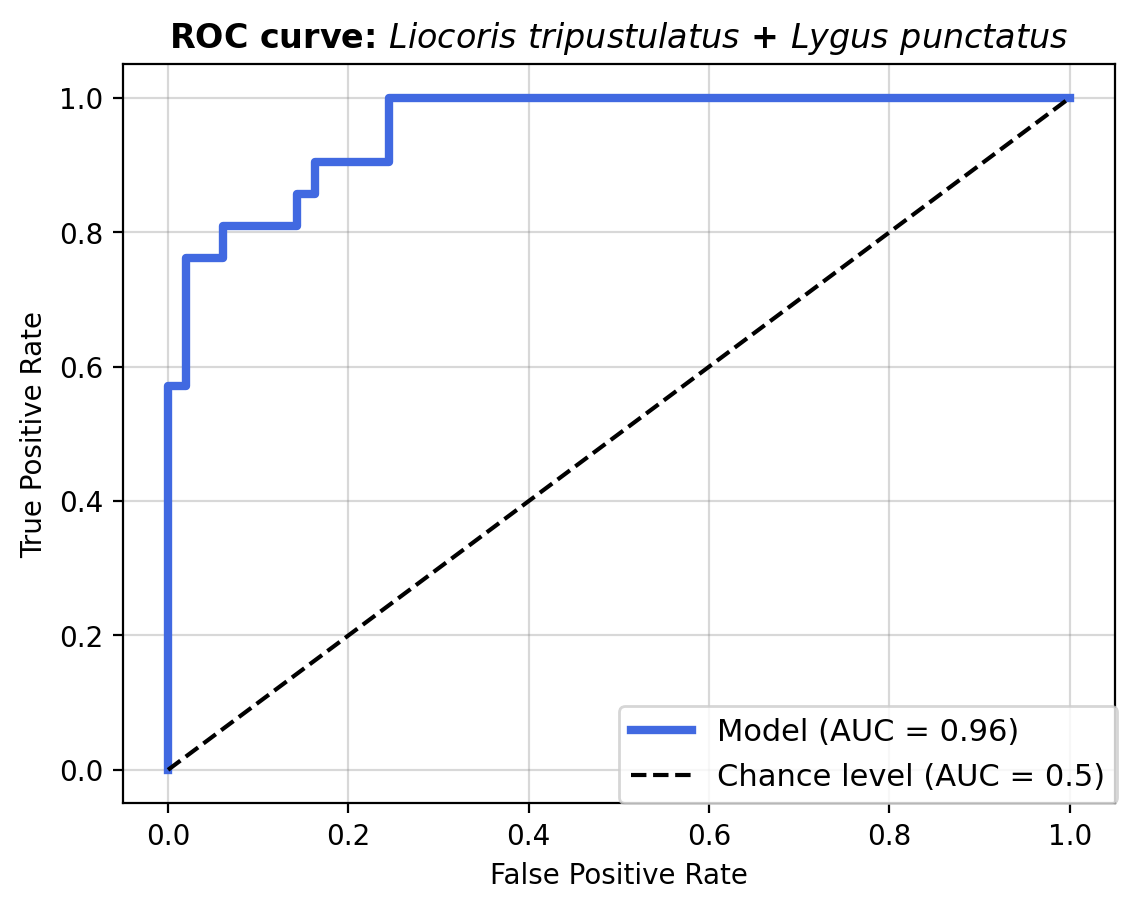

In [33]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_test.values,
    final_logreg.predict_proba(X_test[SELECTED_FEATURES])[:, 1],
    name=f"Model",
    color="royalblue",
    plot_chance_level=True,
    ax=ax,
    lw=3
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"ROC curve: $\it{Liocoris}$ $\it{tripustulatus}$ + $\it{Lygus}$ $\it{punctatus}$", fontweight="bold")

plt.legend(fontsize=11, loc=[0.5, 0])
ax.set_facecolor((1.0, 1.0, 1.0))
plt.grid(color="grey", alpha=0.3, which="both")
plt.savefig("roc_tri-pun.png", dpi=600)
plt.show()

Coefficients

In [34]:
df_final_coefs = pd.DataFrame({
    f"logreg": [final_model.intercept_[0], *final_model.coef_.tolist()[0]],
}, index = ["intercept", *SELECTED_FEATURES])
df_final_coefs.T

,intercept,bio08,bio09,bio11,bio17
logreg,-1.407235,-0.192497,-0.750891,-1.476057,-0.308727


In [35]:
df_final = df_final_coefs.T

In [36]:
X_test_scaled = pd.DataFrame(logreg_cv[0].transform(X_test[SELECTED_FEATURES]), columns = SELECTED_FEATURES)
X_train_scaled = pd.DataFrame(logreg_cv[0].transform(X_train[SELECTED_FEATURES]), columns = SELECTED_FEATURES)
X_all_scaled = pd.DataFrame(logreg_cv[0].transform(X[SELECTED_FEATURES]), columns = SELECTED_FEATURES)

In [37]:
simple_explainer = shap.Explainer(
    final_model, X_train_scaled, feature_names=SELECTED_FEATURES
)
shap_values_train = simple_explainer.shap_values(X_train_scaled)
shap_values_test = simple_explainer.shap_values(X_test_scaled)
shap_all_values = simple_explainer.shap_values(X_all_scaled)

SHAP Summary

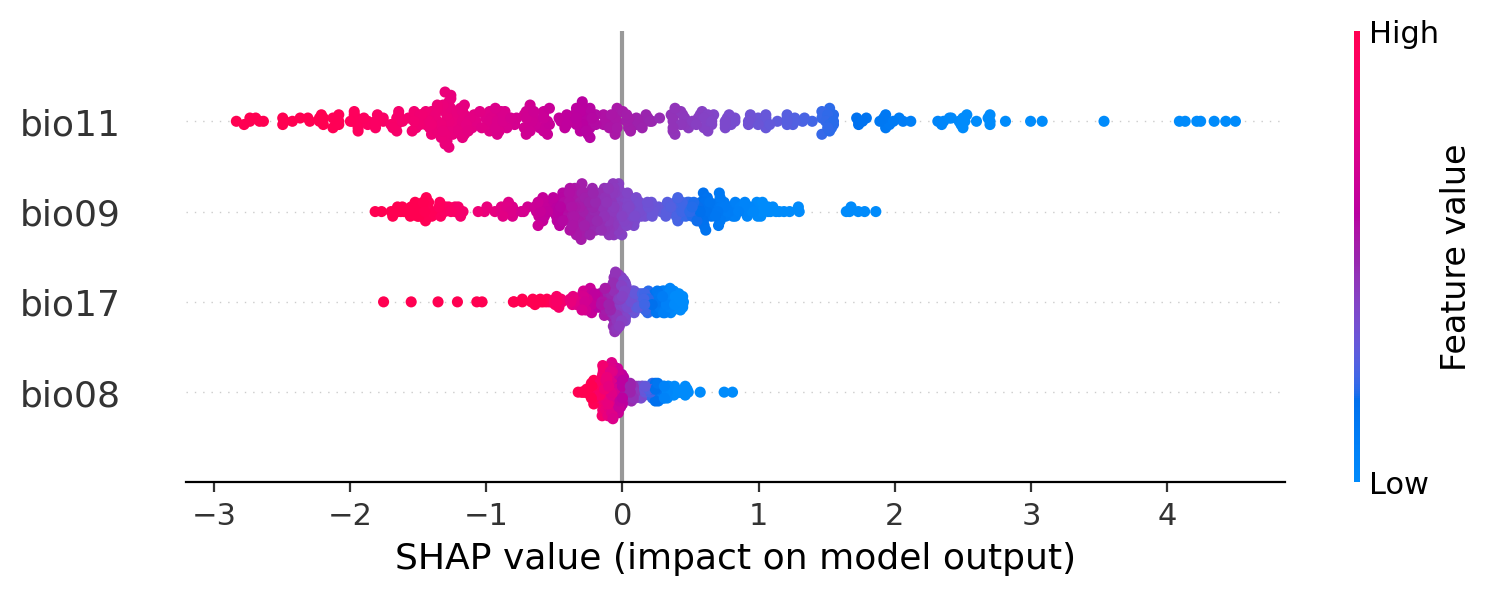

In [38]:
shap.initjs()
shap.summary_plot(
    shap_all_values, X_all_scaled, class_names=CLASSES,
    color = lambda idx: COLOR_MAP[idx]            
)

Partial dependence plots - PDPs

  0%|          | 0/4 [00:00<?, ?it/s]

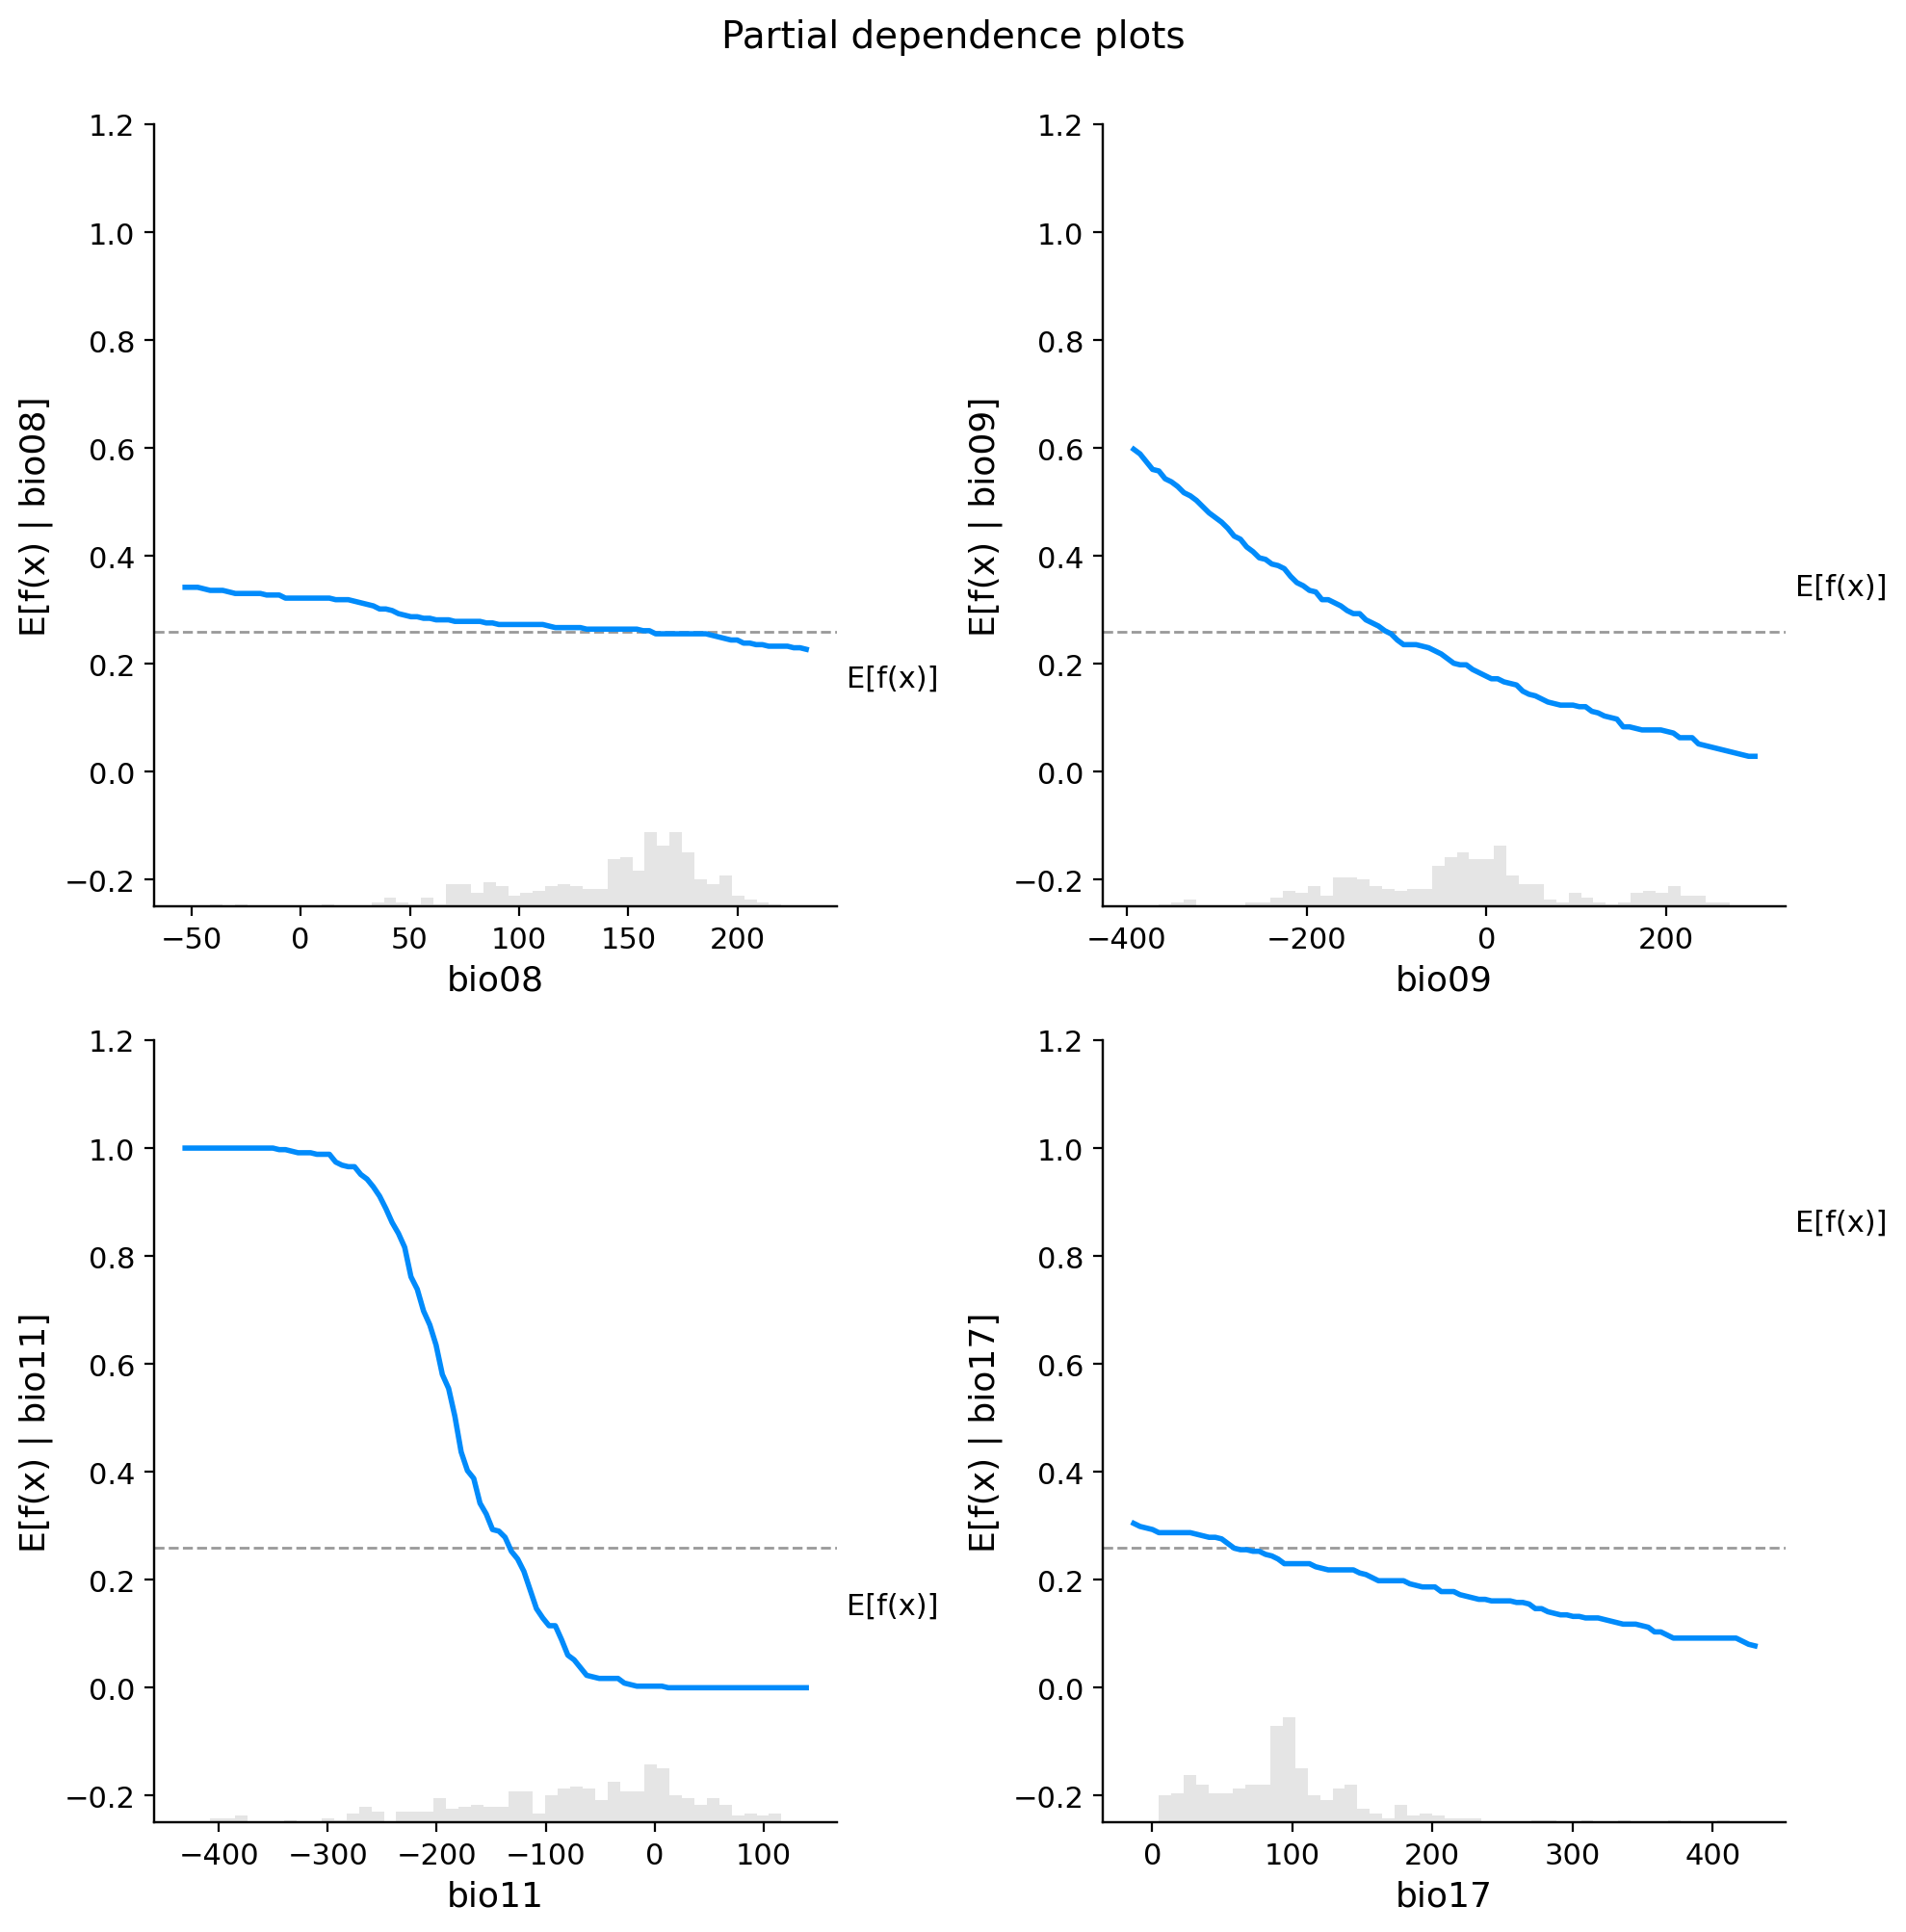

In [40]:
n_features = len(SELECTED_FEATURES)
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize= (10, 10))

for feat_id, feat in tqdm.notebook.tqdm(enumerate(SELECTED_FEATURES), total=n_features):
    x_idx, y_idx = feat_id // n_rows , feat_id % n_cols 
    fig, ax = shap.partial_dependence_plot(
        feat,
        final_logreg.predict,
        X[SELECTED_FEATURES],
        shap_values=shap_values_test,
        model_expected_value=True,
        feature_expected_value=False,
        show=False,
        ice=False,
        ax=axes[x_idx][y_idx]

    )
    ax.set_ylim((-0.25, 1.2))
    
plt.suptitle("Partial dependence plots", y = 1, fontsize=14)
plt.tight_layout()
plt.savefig("pdp_tri-pun.png", dpi=600)
plt.show()